# Exploatory Data Analysis

While I was conducting Storytelling project, I wanted to check two things: 1) if polarity and helpfulness rating are independent (i.e., regardless of helpfulness rating, there is NO siginificant difference in polarity) and 2) if overall rating and helpfulness rating are independent. Therefore, in this EDA project, I will perform statistical test to confirm these hold truth in the same order.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

sns.set(style="whitegrid")
plt.style.use('seaborn')

In [2]:
## read dataframe from story telling procedure
dff = pd.read_csv('df_train_v3.csv.gz', compression='gzip', parse_dates=['reviewTime'], low_memory=False)

In [3]:
## extract features we want to use
df = dff[['polarity', 'overall', 'helpfulness']]
df.head(3)

,polarity,overall,helpfulness
0,0.256913,3.0,5.0
1,-0.016427,3.0,2.0
2,-0.022692,1.0,5.0


### Visualization the problems

Before we start, let us see how the problem is laid out. 

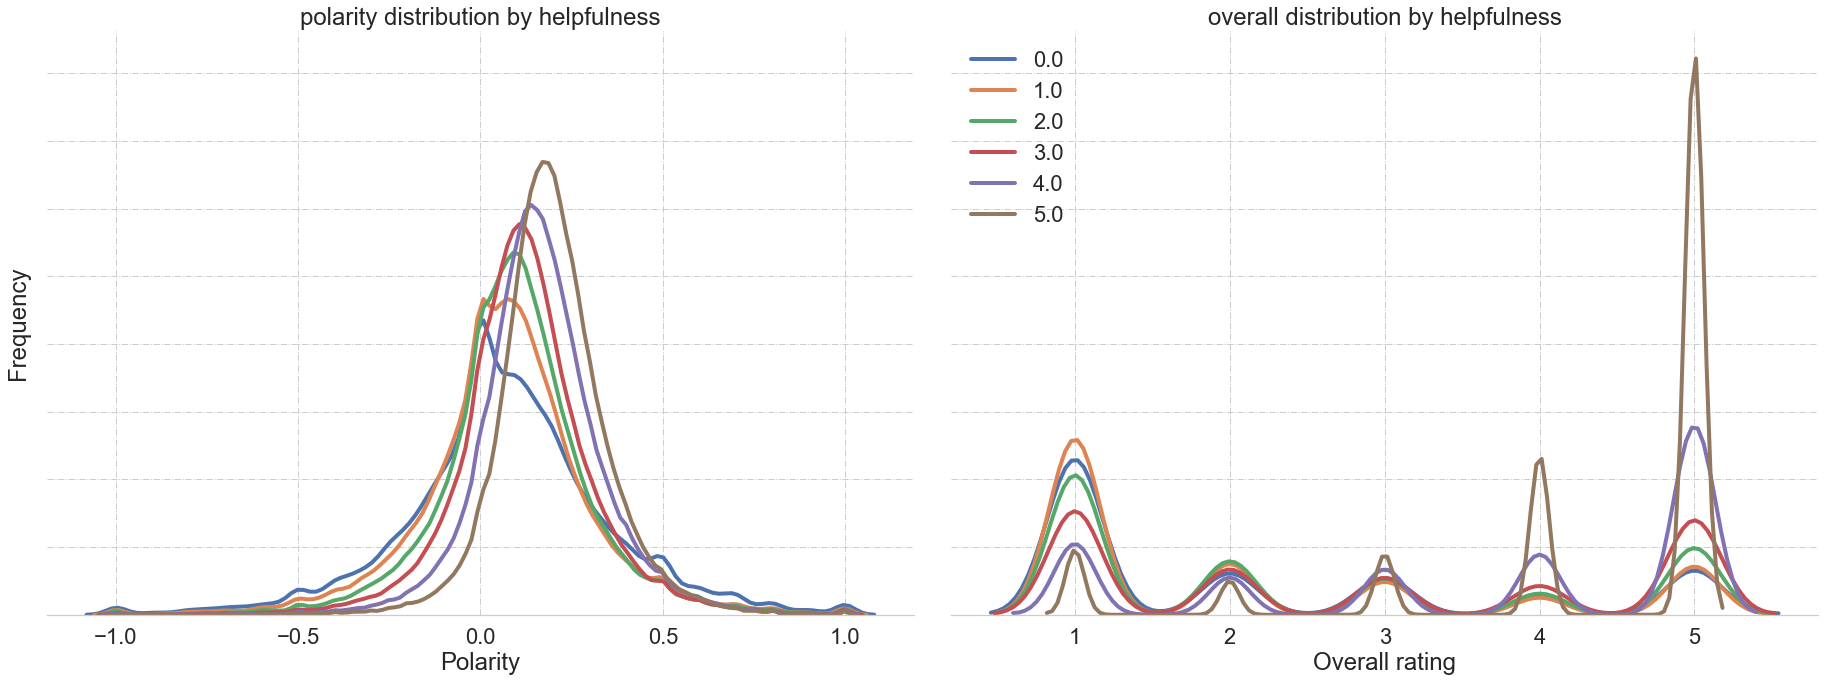

In [4]:
melted = df.melt(id_vars=['helpfulness'], value_vars=['polarity', 'overall'])

sns.set(style='whitegrid', font_scale=2, rc={"lines.linewidth":4, 'grid.color': '.8', 'grid.linestyle':'dashdot'})
g = sns.FacetGrid(melted, hue='helpfulness', col='variable', height=10, aspect=1.3, sharex=False)
g.map(sns.kdeplot, 'value')
g.set_titles('{col_name} distribution by helpfulness')
sns.despine(right=True, top=True, left=True)
g.axes[0,0].set_xlabel('Polarity')
g.axes[0,1].set_xlabel('Overall rating')
g.axes[0,0].yaxis.set_ticklabels([])
g.axes[0,0].set_ylabel('Frequency')
plt.legend(loc='upper left');

# 1. Polarity & Helpfulness

Now, I will check if polarity and helpfulness are independent (Null hypothesis; Ho). Since we have 6 rating scores (0.0 - 5.0) let us pick two extreme case of helpfulness 0.0 and 5.0 as our testing sample.

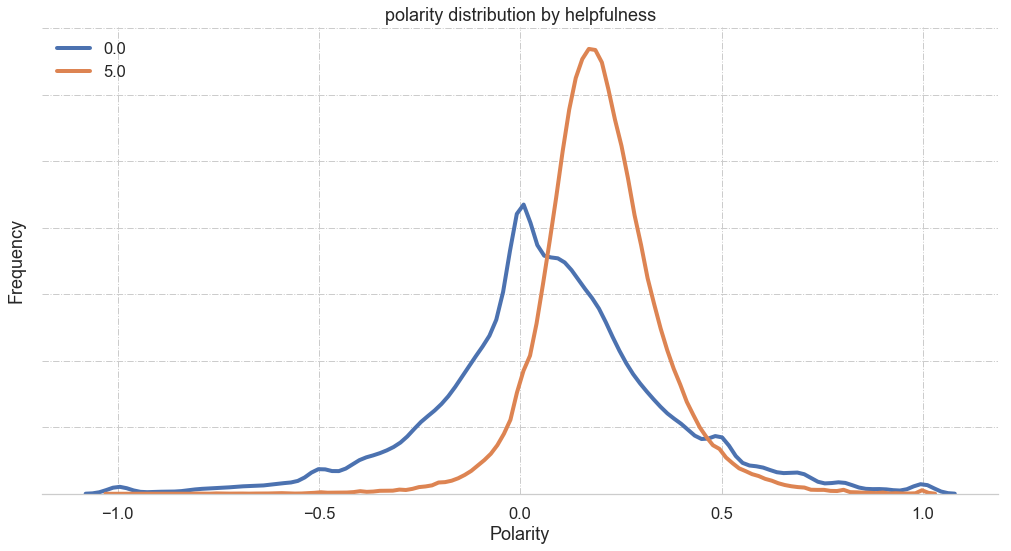

In [5]:
melted = df[df['helpfulness'].isin([0.0, 5.0])].melt(id_vars=['helpfulness'], value_vars=['polarity'])

sns.set(style='whitegrid', font_scale=1.5, rc={"lines.linewidth":4, 'grid.color': '.8', 'grid.linestyle':'dashdot'})
g = sns.FacetGrid(melted, hue='helpfulness', col='variable', height=8, aspect=1.8, sharex=False)
g.map(sns.kdeplot, 'value')
g.set_titles('{col_name} distribution by helpfulness')
sns.despine(right=True, top=True, left=True)
g.axes[0,0].set_xlabel('Polarity')
g.axes[0,0].yaxis.set_ticklabels([])
g.axes[0,0].set_ylabel('Frequency')
plt.legend(loc='upper left');

In [6]:
## split data into sub-samples of helpfulness (0 & 5)
pol = df[df['helpfulness'].isin([0.0, 5.0])]['polarity']
pol_0 = df[df['helpfulness']==0.0]['polarity']
pol_5 = df[df['helpfulness']==5.0]['polarity']

print("Number of reviews with helpfulness rating 0.0:", pol_0.shape[0])
print("Number of reviews with helpfulness rating 5.0:", pol_5.shape[0])
print("Total sample size is:", pol.shape[0])

Number of reviews with helpfulness rating 0.0: 49418
Number of reviews with helpfulness rating 5.0: 370551
Total sample size is: 419969


At first glance, we can see their mean locations are different and sample size is 419969 much greater than 30 which is commonly accepted as threshold number for CLT. Therefore, we can apply CLT. As to the assessment of the problem, this is where significance tests can play a role. Because by definition, significancce tests tell us whether an ovserved effect, such as difference between two means or a correlation between two variables, could reasonably __occur "just by chance"__ in selecting a random sample. If not, we have evidence that the effect observed in the sample relects an effect that is present in the population. We can consider three options: two-sample t-test, permutation tests, or chi-squared. I will conduct t-test. Once we assume our case is by chance, we can presume polarity and helpfulness do not influence each other: independent.

* Ho: There is NO significanct difference in mean polarity based on helpfulness rating
* Ha: There is significant difference in mean polarity based on helpfulness rating

Simply put, 

* Ho: $\mu_0$ = $\mu_5$
* Ha: $\mu_0$ $\neq$ $\mu_5$

### t-test

p-value: 0.0
The null hypothesis can be rejected: There is LIKELY significanct difference in mean polarity based on helpfulness rating
95% confidence interval of normal distribution is [-0.003, 0.003]


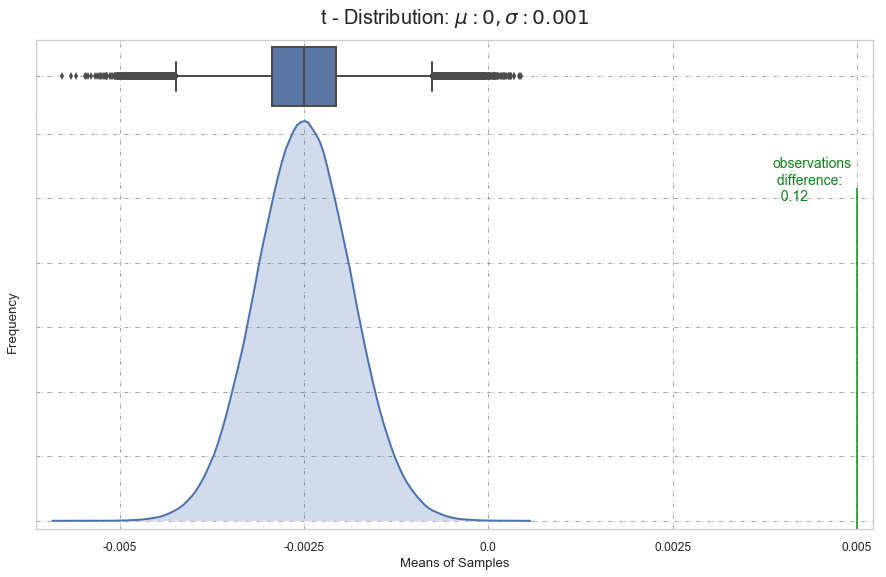

In [7]:
## mean terms
x_bar_0 = np.mean(pol_0) # mean polarity of helpfulness 0.0 reviews
x_bar_5 = np.mean(pol_5) # mean polarity of helpfulness 5.0 reviews
mu = 0 # mean of the sample means: 0 because we assume no difference

## std terms
s_0 = np.std(pol_0, ddof=1) # sample standard deviation of helpfulnee 0.0 reviews
s_5 = np.std(pol_5, ddof=1) # sample standard deviation of helpfulnee 5.0 reviews
sigma = np.sqrt((s_0**2/len(pol_0)) + (s_5**2/len(pol_5))) # mean sample standard deviation

## observed value
observed = x_bar_5 - x_bar_0

## t-score
t_score = (observed - mu) / sigma

## using above values, let us generate the t distribution of size 1,000,000
t_dist = stats.t.rvs(df=len(pol)-1, loc=mu, scale=sigma, size=1000000)

## define significance level: 0.05
alpha = 0.05

## p-value
p_value = np.sum(t_dist > observed) / len(t_dist)

## null hypothesis: There is NO significanct difference in mean polarity based on helpfulness rating
print("p-value:", p_value)
if p_value < alpha:
    print("The null hypothesis can be rejected: There is LIKELY significanct difference in mean polarity based on helpfulness rating")
else:
    print("The null hypothesis cannot be rejected: There is NO significanct difference in mean polarity based on helpfulness rating")

## find 95% confidence interval
left, right = np.percentile(t_dist, [2.5, 97.5])
print("95% confidence interval of normal distribution is [{:.3f}, {:.3f}]".format(left, right))


## visualization
sns.set(style='whitegrid', font_scale=1.1, rc={"lines.linewidth":2})
f, (ax_box, ax_hist) = plt.subplots(2, figsize = (15,9), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

ax1 = sns.distplot(t_dist, hist=False, ax = ax_hist, kde_kws={'shade':True})
ax2 = sns.boxplot(t_dist, hue = 0.5, ax = ax_box)

ax1.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax1.text(0.88, 0.79, 'observations\n difference:\n  {:.2f}'.format(observed), 
         transform=ax1.transAxes, color='#0f841b', fontsize=14);
plt.title(r't - Distribution: $\mu: {}, \sigma: {:.3f}$'.format(mu, sigma), y = 1.2, fontsize=20)
plt.xlabel('Means of Samples')
plt.ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)
ax1.vlines(0.015, 0,0.82, transform=ax1.get_xaxis_transform(), alpha=0.7, color='green', linewidth=2)
ax1.set_xticklabels(["", -0.0050, -0.0025, 0.0000, 0.0025, 0.0050, " ", "......", " ", "0.12"])
ax1.yaxis.set_ticklabels([])

for ax in [ax1, ax2]:
    ax.grid(color="grey", linestyle=(0, (3.5, 1.5, 1, 5)), alpha=0.7)
    ax.margins(0.02)

According to t-test, there is probably significant difference in mean polarity based on helpfulness rating; therefore  I conclude that polarity and helpfulness are not independent of each other. All in all, we can presume, positive reveiws tend to get higher helpfulness rating. 

# 2. Overall & Helfpulness ratings
Even though I decided to remove overall rating from features, in this section I will conduct independence test between overall rating and helpfulness rating out of curiosity. Since both overall and helpfulness are discrete values to test independece, we can apply chi-squared test. The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories. In practice, chi-squared tests are usually used to attempt rejection of the null hypothesis that the data are independent. We use null hypothesis that claims independece between variables; therefore, if we reject the null hypothesis, we conclude that those variables are not independent. In our case, 

* Ho: Overall rating and helpfulness rating are independent
* Ha: Overall rating and helpfulness rating are NOT independet

### Chi-squared test

In [8]:
## compute a contingency table of overall rating and helpfulness rating
table_w_total = pd.crosstab(index=df['overall'], columns=df['helpfulness'], margins=True, margins_name='total')
## this one is used for chi-squared test
table = pd.crosstab(index=df['overall'], columns=df['helpfulness'])
## print
table_w_total

helpfulness,0.0,1.0,2.0,3.0,4.0,5.0,total
overall,,,,,,,
1.0,25946,41436,42973,36879,51139,27245,225618
2.0,6910,11916,16469,16185,26619,14287,92386
3.0,6035,7759,11179,13226,32715,25629,96543
4.0,3141,4015,6531,10294,43082,67361,134424
5.0,7386,11376,20539,33658,136077,236029,445065
total,49418,76502,97691,110242,289632,370551,994036


In [9]:
## chi: the test statistic
## p: the p-value of the test
## dof: degrees of freedom (ref: observed.size - sum(observed.shape) + observed.ndim - 1)
## expected: the expected frequencies, based on the marginal sums of the table
chi, p, dof, expected = stats.chi2_contingency(table)

print("Chi-sqared value: {:.3f}".format(chi))
print("p-value:", p)
print("degrees of freedom:", dof)

Chi-sqared value: 239391.854
p-value: 0.0
degrees of freedom: 20


With 20 degrees of freedom and a chi-squared statistic of 239391.9, looking these values up on the chi-squared chart yields a very small p-value ( << 1e-5). Therefore the result is significant and we reject the null hypothesis in favor of alternative hypothesis: __overall rating and helpfulness rating are not independent__. 

However, this result is not much of shocking, because in storytelling project they showed 0.4 of correlation which means they are highly correlated. In this regard, this chi-squared test simply confirmed that result.